In [10]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from pytorchcv.model_provider import get_model as ptcv_get_model # model
import sys, os
import easydict
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.init as init
#%matplotlib inline 

# enable cuda devices
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from meta_neural_network_architectures import VGGReLUNormNetwork, ResNet12
from utils.parser_utils import get_args
from data import MetaLearningSystemDataLoader
from experiment_builder import ExperimentBuilder
from utils.basic import show_batch
from few_shot_learning_system import MAMLFewShotClassifier
import prompters
import torchvision.transforms as T

from data_augmentation import mixup_data, cutmix_data, random_flip, random_flip_like_torchvision
from torchvision.transforms.functional import to_pil_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def make_random_init_params(reference_params):
    random_init = {}
    for key, value in reference_params.items():
        if (
            'layer_dict' in key and
            'prompt' not in key and
            'norm_layer' not in key and
            'inner_loop_optimizer' not in key
        ):
            new_param = torch.empty_like(value)

            if 'bias' in key:
                # bias는 zero initialization
                random_init[key] = torch.zeros_like(value)
            else:
                # weight는 Xavier uniform
                init.xavier_uniform_(new_param)
                random_init[key] = new_param

    return random_init

def get_model_distance_from_fixed_random_init(random_init_params, checkpoint_dir, checkpoint_names, device='cpu'):
    distances = []

    for ckpt_name in checkpoint_names:
        ckpt_path = os.path.join(checkpoint_dir, ckpt_name)
        ckpt = torch.load(ckpt_path, map_location=device)
        current_params = ckpt['network']

        total_distance = 0.0
        for key in random_init_params.keys():
            p0 = random_init_params[key].float()
            pt = current_params[key].float()
            total_distance += torch.norm(p0 - pt).item() ** 2

        distances.append(np.sqrt(total_distance))

    return distances

def plot_model_distance(epochs, dist1, dist2, label1='Ours', label2='MAML'):
    plt.figure(figsize=(8, 5))

    sorted_epochs = sorted(epochs)

    plt.plot(sorted_epochs, dist2, label=label2, linestyle='dashed', linewidth=2.5)
    plt.plot(sorted_epochs, dist1, label=label1, linestyle='solid', linewidth=2.5)

    # 눈금 조절: 0부터 10단위 + 마지막 99 포함
    xticks = list(range(0, 100, 10))
    if sorted_epochs[-1] not in xticks:
        xticks.append(sorted_epochs[-1])

    plt.xticks(xticks, fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.xlabel('Epoch', fontsize=16)
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.show()

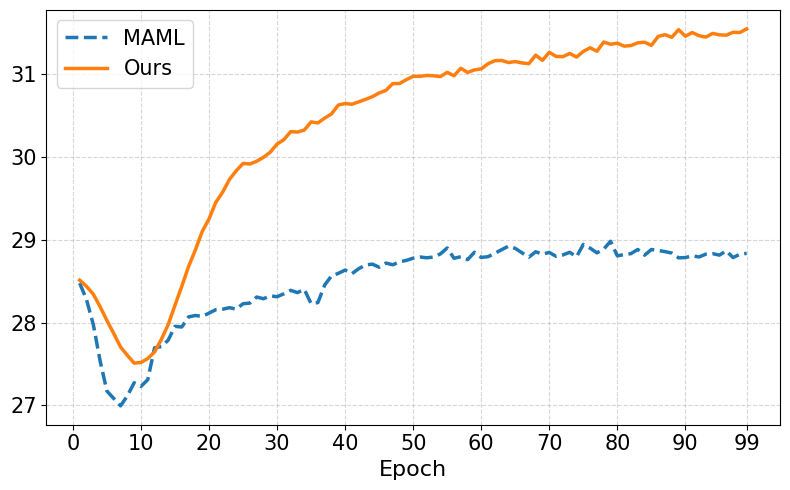

In [12]:
# 실험 세팅
prompt_ckpt_dir = '../MAML_Prompt_padding_5way_5shot_filter128_miniImagenet/saved_models'
baseline_ckpt_dir = '../MAML_5way_5shot_filter128_miniImagenet/saved_models'

# 공통된 epoch 리스트 생성
epochs = list(range(1, 100))
prompt_checkpoints = [f"train_model_{e}" for e in epochs]
baseline_checkpoints = [f"train_model_{e}" for e in epochs]

# 기준 파라미터 추출
sample_ckpt = torch.load(os.path.join(prompt_ckpt_dir, 'train_model_1'), map_location='cpu')
reference_params = sample_ckpt['network']
random_init_params = make_random_init_params(reference_params)

# distance 계산
prompt_dist = get_model_distance_from_fixed_random_init(random_init_params, prompt_ckpt_dir, prompt_checkpoints)
baseline_dist = get_model_distance_from_fixed_random_init(random_init_params, baseline_ckpt_dir, baseline_checkpoints)

# 시각화
plot_model_distance(epochs, prompt_dist, baseline_dist, label1='Ours', label2='MAML')

In [13]:
def get_weight_norm_per_epoch(checkpoint_dir, checkpoint_names, device='cpu'):
    norms = []

    for ckpt_name in checkpoint_names:
        ckpt_path = os.path.join(checkpoint_dir, ckpt_name)
        ckpt = torch.load(ckpt_path, map_location=device)
        params = ckpt['network']

        total_norm_sq = 0.0
        for key, value in params.items():
            if (
                'layer_dict' in key and
                'prompt' not in key and
                'norm_layer' not in key and
                'inner_loop_optimizer' not in key
            ):
                total_norm_sq += torch.norm(value.float()).item() ** 2

        norms.append(np.sqrt(total_norm_sq))

    return norms


In [14]:
prompt_weight_norms = get_weight_norm_per_epoch(prompt_ckpt_dir, prompt_checkpoints)
baseline_weight_norms = get_weight_norm_per_epoch(baseline_ckpt_dir, baseline_checkpoints)

In [15]:
def plot_weight_norm(epochs, norm1, norm2, label1='Ours', label2='MAML'):
    plt.figure(figsize=(8, 5))

    sorted_epochs = sorted(epochs)

    plt.plot(sorted_epochs, norm2, label=label2, linestyle='dashed', linewidth=2.5)
    plt.plot(sorted_epochs, norm1, label=label1, linestyle='solid', linewidth=2.5)

    xticks = list(range(0, 100, 10))
    if sorted_epochs[-1] not in xticks:
        xticks.append(sorted_epochs[-1])

    plt.xticks(xticks, fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Weight Norm', fontsize=16)
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.show()

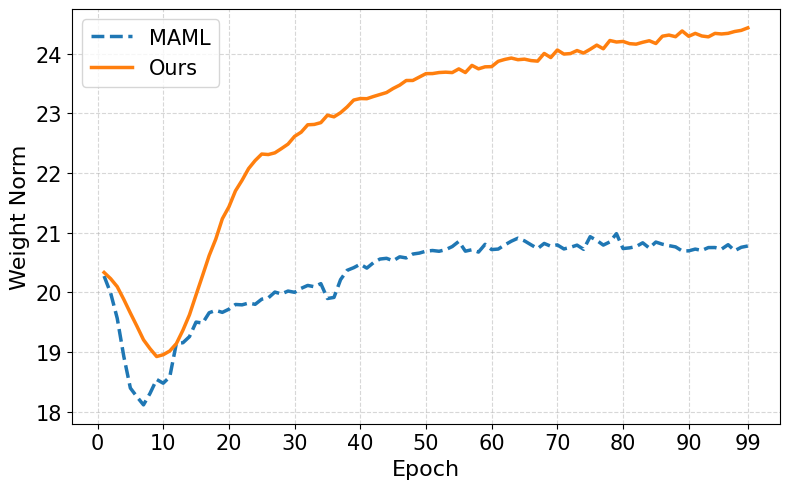

In [16]:
plot_weight_norm(epochs, prompt_weight_norms, baseline_weight_norms, label1='Ours', label2='MAML')